In [16]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torchinfo import summary 
import numpy as np
import matplotlib.pyplot as plt
import pprint
    
from CharToIndex import CharToIndex
from MyDatasets import BaseDataset as MyDataset
from MyDatasets import Cross_Validation  
from MyCustomLayer import TenHotEncodeLayer


import time
import math

In [17]:
chars_file_path = "/net/nfs2/export/home/ohno/CR_pytorch/data/tegaki_katsuji/all_chars_3812.npy"
tokens = CharToIndex(chars_file_path)
file_path = "/net/nfs2/export/home/ohno/CR_pytorch/data/tegaki_katsuji/tegaki.npy"
data = np.load(file_path,allow_pickle=True)

EMBEDDING_DIM = 10
HIDDEN_SIZE = 128
BATCH_SIZE = 64
VOCAB_SIZE = len(tokens)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tegaki_dataset = MyDataset(data,chars_file_path,device=device)

In [18]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def show_ans_pred(answers,predictions):
    for ans,pred in zip(answers,predictions):
        correct = '✓' if ans.item() == pred.item() else '✗'
        print(f'{tokens.get_decoded_char(ans.item())}{tokens.get_decoded_char(pred.item()):2} {correct}',end=' ')
    print()



def train(model,train_dataloader,learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    batch_size = next(iter(train_dataloader))[0].size(0)
    running_loss = 0
    accuracy = 0

    model.train()
    for i,(x,y) in enumerate(train_dataloader):
        output = model(x)
        loss = criterion(output, y) #損失計算
        prediction = output.data.max(1)[1] #予測結果
        accuracy += prediction.eq(y.data).sum().item()/batch_size
        optimizer.zero_grad() #勾配初期化
        loss.backward(retain_graph=True) #逆伝播
        optimizer.step()  #重み更新
        running_loss += loss.item()

    loss_result = running_loss/len(train_dataloader)
    accuracy_result = accuracy/len(train_dataloader)

    return loss_result,accuracy_result

    
def eval(model,valid_dataloader,is_show_ans_pred=False):
    accuracy = 0
    batch_size = next(iter(valid_dataloader))[0].size(0)
    model.eval()
    for x,y in valid_dataloader:
        output = model(x)
        prediction = output.data.max(1)[1] #予測結果
        accuracy += prediction.eq(y.data).sum().item()/batch_size
        if is_show_ans_pred:
            ans_pred_list=show_ans_pred(y,prediction)
            print(ans_pred_list)
        
    return accuracy/len(valid_dataloader)


In [19]:
#hot encode用
class Proofreader(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size,n_layers):
        super(Proofreader, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers  = n_layers
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.encoder = TenHotEncodeLayer(output_size)
        self.rnn = nn.RNN(input_size, self.hidden_dim, batch_first=True)
        self.fc = nn.Linear(self.hidden_dim, output_size)
        self.dropout = torch.nn.Dropout(p=0.5)  
        self.to(self.device)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size).to(self.device)

        x = self.encoder(x)
        out, hidden = self.rnn(x, hidden)
        out = out[:,-1,:]
        out = self.dropout(out)
        out = self.fc(out)
        
        return out


In [20]:
final_accuracies = []
final_losses = []

cross_validation = Cross_Validation(tegaki_dataset)
k_num = cross_validation.k_num #デフォルトは10

##学習
for i in range(k_num):
    train_dataset,valid_dataset = cross_validation.get_datasets(k_idx=i)

    print(f'Cross Validation: k=[{i+1}/{k_num}]')
    train_dataloader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,drop_last=True) #訓練データのみシャッフル
    valid_dataloader=DataLoader(valid_dataset,batch_size=BATCH_SIZE,shuffle=False,drop_last=True)
    model = Proofreader(VOCAB_SIZE, hidden_dim=HIDDEN_SIZE, output_size=VOCAB_SIZE, n_layers=1)
    # model.load_state_dict(torch.load("data/tegaki_katsuji/pre_trained_model.pth"))

    for v,a in valid_dataloader:
        for idx in a:
            print(tokens.get_decoded_char(idx.item()),end='')
    print('\n')


    continue


    epochs = 100
    acc_record=[]
    loss_record=[]
    start = time.time() #開始時間の設定

    for epoch in range(1,epochs+1):
        loss,acc = train(model,train_dataloader,learning_rate=0.01)

        valid_acc = eval(model,valid_dataloader)
        loss_record.append(loss)
        acc_record.append(valid_acc)

        if epoch%10==0:
            print(f'epoch:[{epoch:3}/{epochs}] | {timeSince(start)} - loss: {loss:.7},  accuracy: {acc:.7},  valid_acc: {valid_acc:.7}')
            start = time.time() #開始時間の設定
        # print(f'epoch:[{epoch:3}/{epochs}] | {timeSince(start)} - loss: {loss:.7},  accuracy: {acc:.7},  valid_acc: {valid_acc:.7}')
        # start = time.time() #開始時間の設定

    print(f'final_loss: {loss_record[-1]:.7},   final_accuracy:{acc_record[-1]:.7}\n\n')
    final_accuracies.append(acc_record[-1])
    final_losses.append(loss_record[-1])

Cross Validation: k=[1/10]
ﾃﾑ工学講座では､ｶﾒﾗ､ﾏｲｸなどの各種ｾﾝｻにより計測された大量の情報をｺﾝﾋﾟｭｰﾀに取り込み､人間と機械に適切な情報を提供する人工知能ｼｽﾃﾑについて研究します｡この研究により､より人間らしい快適な生活ができる高度情報化社会の構築を目指します｡人間情報学講座では､人間の知覚､認知､行動に関する人間情報学の基礎的･応用的研究を通して､人間の認識能力や､人間の反応や行動に合わせた特性を備えた､人に優しいｺﾝﾋﾟｭｰﾀｼｽﾃﾑを開発しています｡いつもご利用いただきまして､誠にありがとうございます｡さて､お客様の定額･定期預金は､右記のとおり満期を迎えますので､ご案内いたします｡今後とも一層のご愛顧を賜りますようお願い申し上げます｡(払戻しおよび預け替えのお手続きの際に必要となる書類等)貯金証書､総合口座通帳(無通帳型総合口座の場合はｷｬｯｼｭｶｰﾄﾞ)､お届け印およびご本人であることを確認できる証明書類(お名前･ご住所･生年月日の入った運転免許証等､法人名義の場合は登記事項証明書等､団体名義の場合は規約の写し等もあわせてお持ちください)このことについて､日本学術振興会から別添のとおり通知がありました｡つきましては同封の研究者使用ﾙｰﾙと科研費ﾊﾝﾄﾞﾌﾞｯｸをご一読頂き､研究費の適正な使用についてご尽力頂きますようお願いします｡化学は階段状に発展する｡革命的な理論が出るとﾊﾟﾗﾀﾞｲﾑが大きく転換し(いわゆるﾌﾞﾚｰｸｽﾙｰが起こり)広い分野へ適用されていく｡ｼﾞｬﾝﾌﾟして一段上に昇るのである｡しかしその後､どんどん問題が詳細になり､平板な通常科学の時代を迎える｡いわば踊り場である｡そこに何らかの矛盾や適用不可能な課題があれば､そこからまた新たな飛躍が起こるのだ｡ところが､踊り場が広い場合､一見してすべてが解決できるかのように錯覚することもある｡そんなときに決まって言われるのが｢科学の終焉｣である｡科学は行き着くところまで行き着いた､もう何もすることはない､と考えたくなるからだ｡技術開発にとっても科学が重要であることが認識されるにつれ､技術産業において意識的に科学を取り入れる試みがなされるようになった｡すでに一九世紀においてﾄﾞｲﾂで最初の産業用化学実験所が設立されたのに続きいくつかの産業で付属の研究機関が創

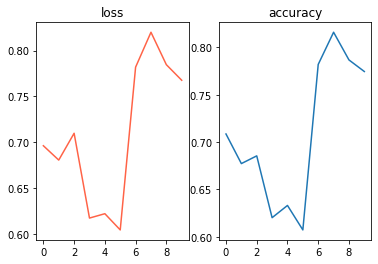

final_accuracy:[]
finall_loss:[]
average_acc: nan
average_loss: nan


/net/nfs2/export/home/ohno/CR_pytorch/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/net/nfs2/export/home/ohno/CR_pytorch/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
fine=[0.6963315217391305, 0.6807065217391305, 0.7099184782608695, 0.6175271739130435, 0.6222826086956522, 0.6046195652173914, 0.7819293478260869, 0.8199728260869565, 0.7846467391304348, 0.7676630434782609]
orig=[0.7085597826086957, 0.6773097826086957, 0.6854619565217391, 0.6202445652173914, 0.6331521739130435, 0.6073369565217391, 0.7819293478260869, 0.8158967391304348, 0.7866847826086957, 0.7744565217391305] 
fig = plt.figure()
fig1 = fig.add_subplot(1, 2, 1)
fig1.plot(fine,color="tomato")
fig1.set_title("loss")
fig2 = fig.add_subplot(1, 2, 2)
fig2.plot(orig)
fig2.set_title("accuracy")


plt.show()


print(f'final_accuracy:{final_accuracies}\nfinall_loss:{final_losses}')
print(f'average_acc: {np.mean(final_accuracies)}\naverage_loss: {np.mean(final_losses)}')

plt.savefig("/net/nfs2/export/home/ohno/CR_pytorch/result.png")
